# Grid Search with XGBoost

**Goal:** test multiple hyperparameter combinations to find the best `XGBRegressor` model.

**Dataset:** `database.csv`


In [1]:
# Dependencias
# If you do not have xgboost installed, run:
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from xgboost import XGBRegressor

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load data
file_path = "../database.csv"
df = pd.read_csv(file_path)

df.head()

,Estado,Ciudad,Colonia/Municipio,Tipo de alojamiento,Numero de cuartos,Numero de baños,Numero de huéspedes,Precio por noche estimado (MXN),Ocupación promedio (%)
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Cleaning and normalization


In [3]:
rename_map = {
    "Numero de cuartos": "num_cuartos",
    "Numero de baños": "num_banos",
    "Numero de huéspedes": "num_huespedes",
    "Precio por noche estimado (MXN)": "precio_noche_mxn",
    "Ocupación promedio (%)": "ocupacion_promedio",
    "Tipo de alojamiento": "tipo_alojamiento",
    "Colonia/Municipio": "colonia_municipio",
}

df = df.rename(columns=rename_map)

df.head()

,Estado,Ciudad,colonia_municipio,tipo_alojamiento,num_cuartos,num_banos,num_huespedes,precio_noche_mxn,ocupacion_promedio
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Features and target


In [4]:
features = [
    "Estado",
    "Ciudad",
    "colonia_municipio",
    "tipo_alojamiento",
    "num_cuartos",
    "num_banos",
    "num_huespedes",
    "ocupacion_promedio",
]

target = "precio_noche_mxn"

X = df[features]
y = df[target]

In [5]:
categorical_features = ["Estado", "Ciudad", "colonia_municipio", "tipo_alojamiento"]
numeric_features = ["num_cuartos", "num_banos", "num_huespedes", "ocupacion_promedio"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

## Grid Search
We define a hyperparameter range to evaluate different combinations.


In [6]:
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model),
    ]
)

param_grid = {
    "model__n_estimators": [200, 500, 800],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 6, 8],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
}

# GridSearch con validación cruzada
# Nota: con pocos datos puede ser inestable; reduce el grid si tarda mucho.
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [7]:
# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Estado',
                                                                          'Ciudad',
                                                                          'colonia_municipio',
                                                                          'tipo_alojamiento']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['num_cuartos',
                                                                          'num_banos',
                                                                          'num_huespedes',
                                                                          'ocupacion_promedio'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=N...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9, 1.0],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 6, 8],
                         'model__n_estimators': [200, 500, 800],
                         'model__subsample': [0.8, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [8]:
# Best hyperparameters
print("Best parameters:")
print(grid.best_params_)

Best parameters:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 800, 'model__subsample': 0.8}


In [9]:
# Evaluación con el mejor modelo
best_model = grid.best_estimator_

preds = best_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 70.90
RMSE: 112.95
R2: 1.00


## Actual vs prediction comparison


In [10]:


# Mostrar todas las filas
pd.set_option('display.max_rows', None)

# Opcional: También ajustar columnas y ancho
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

comparison = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": preds
})

print(comparison)

      Real    Predicción
0     1250   1257.541260
1     1500   1520.709839
2      750    738.139587
3     1350   1379.461914
4     2500   2527.981201
5     1500   1350.883423
6     1125   1052.307373
7     1350   1354.465820
8     1050   1036.405396
9     2520   2291.183350
10    2700   2575.022705
11    1750   1803.208130
12    1350   1350.321655
13    2160   2255.462646
14    1200   1265.237427
15   11700  11051.536133
16    1500   1445.083740
17    1625   1589.665771
18    1800   1745.914185
19    3060   3151.767334
20    1250   1262.940308
21    1375   1283.019165
22    1350   1318.617676
23    1260   1248.772949
24    1980   2059.318359
25    3000   2853.910156
26    1200   1309.932739
27    1000    974.517578
28    2100   1947.414551
29    1170   1355.038818
30    1980   1935.656006
31    6500   6474.054688
32    1000   1005.831421
33    3000   3322.477539
34     562    564.046448
35    1200   1279.220337
36    1500   1446.479980
37    1200   1261.814575
38     650    623.937927


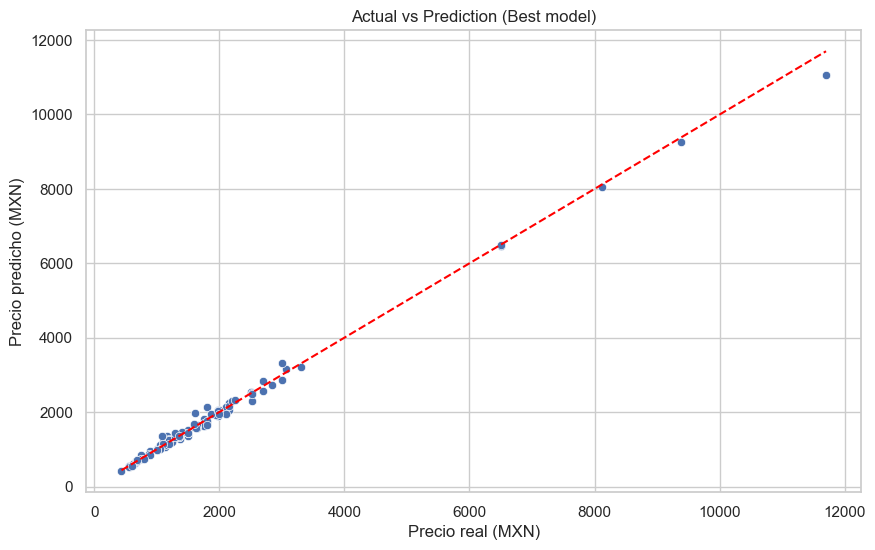

In [11]:
sns.scatterplot(data=comparison, x="Real", y="Predicción")
plt.plot([comparison["Real"].min(), comparison["Real"].max()],
         [comparison["Real"].min(), comparison["Real"].max()],
         color="red", linestyle="--")
plt.title("Actual vs Prediction (Best model)")
plt.xlabel("Precio real (MXN)")
plt.ylabel("Precio predicho (MXN)")
plt.show()

## Conclusions
- Grid search selects the hyperparameter combination with the best RMSE.
- With more data, the model can generalize better.
